# Preparation

<div style="background-color: #d9f2d9">

# Solutions

<p> Solutions will be given in markdown cells with green background. </p>  
<br>

</div>

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, norm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
# configuration

ROOTPATH = 'C:/Users/Jon/Springboard/Assignments/ultimate_challenge/'
#ROOTPATH = 'C:/Users/Jonathon.Poage/Desktop/tempdir_springboard/ultimate_challenge/'

%matplotlib inline

In [3]:
# watermark

%load_ext watermark
%watermark

2019-05-08T14:03:25-07:00

CPython 3.6.8
IPython 7.4.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


### Load the JSON files into DataFrames

In [4]:
# load method 1
df_logins_raw = pd.read_json(ROOTPATH + 'logins.json')

# load method 2
with open(ROOTPATH + 'ultimate_data_challenge.json', 'r') as f:
    datastore = json.load(f)
df_data_raw = pd.DataFrame(datastore)

# Part 1 - Exploratory data analysis

### Data Wrangling

In [5]:
# copy raw data
df_logins = df_logins_raw.copy()

In [6]:
# sort login times
df_logins = df_logins.sort_values('login_time').reset_index(drop=True)

# login counts grouped by 15-minute intervals
df_login_counts_15min = df_logins.resample('15min', on='login_time').count()

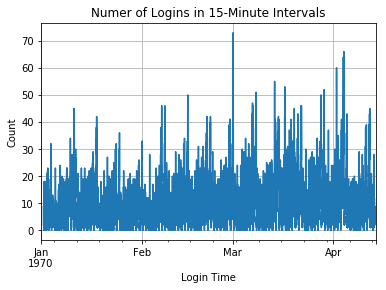

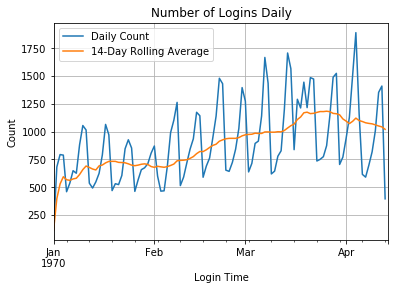

In [7]:
# plot over entire timeseries
ax1a = df_login_counts_15min.plot(legend=False, grid=True)
ax1a.set_ylabel('Count')
ax1a.set_title('Numer of Logins in 15-Minute Intervals')
ax1a.set_xlabel('Login Time')
ax1a.set_xlim([df_logins.login_time.min().date(),
             df_logins.login_time.max().date() + pd.Timedelta(days=1)])
fig1a = plt.gcf()

# daily login counts
df_login_counts_daily = df_logins.resample('D', on='login_time').count()

# rolling averages of daily login counts
df_login_counts_daily['14_day_ra'] = df_login_counts_daily.login_time.rolling(window='14D').mean()

df_login_counts_daily.columns = ["Daily Count", "14-Day Rolling Average"]

# plot daily counts and rolling averages
ax1b = df_login_counts_daily.plot(grid=True)
ax1b.set_ylabel('Count')
ax1b.set_title('Number of Logins Daily')
ax1b.set_xlabel('Login Time')
ax1b.set_xlim([df_logins.login_time.min().date(),
             df_logins.login_time.max().date() + pd.Timedelta(days=1)])
fig1b = plt.gcf()

<div style="background-color: #d9f2d9">
<br>
<p> The time series plots reveal trends in the login rates over time. The time series plot of login counts over 15-minute intervals shows general patterns with timescales on the order of several days. The high density of data points in this plot makes the trends difficult to visualize. A second figure was created using daily login counts, in order to visualize trends more clearly. </p>

<p> The time series plot of daily login counts shows weekly trends. The number of daily logins rises and falls in a similar pattern every seven days. The 14-day rolling average reveals long term trends with timescales on the order of months. Overall, the average login rates tend to increase from January through mid March, after which they tend to decrease through mid April.  
</p>
<br>
</div>

           Average Login Count
Monday              588.200000
Tuesday             662.000000
Wednesday           738.500000
Thursday            797.333333
Friday             1013.866667
Saturday           1291.800000
Sunday             1211.133333


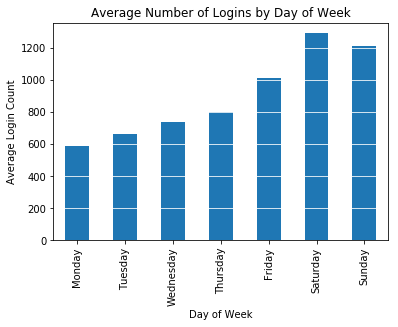

In [8]:
# aggregate by day of week
df_day_of_week_counts = df_login_counts_daily[['Daily Count']].groupby(df_login_counts_daily.index.weekday).mean()
df_day_of_week_counts.index = ['Monday',
                               'Tuesday',
                               'Wednesday',
                               'Thursday',
                               'Friday',
                               'Saturday',
                               'Sunday']
df_day_of_week_counts.columns = ["Average Login Count"]

print(df_day_of_week_counts)

# plot login counts by day of week
ax2 = df_day_of_week_counts.plot(kind='bar', legend=False)
ax2.grid(axis='y', color='w')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Login Count')
ax2.set_title('Average Number of Logins by Day of Week')
fig2 = plt.gcf()

<div style="background-color: #d9f2d9">
<br>
<p> The plot of average login counts for each day of the week shows that, on average, login rates were highest on Saturdays and lowest on Mondays. Most of the logins occured on Fridays, Saturdays, and Sundays.  </p>
<br>
</div>

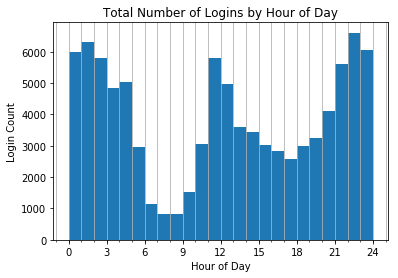

In [9]:
# aggregate by hour of day
df_logins_hour_of_day = df_logins.login_time.apply(lambda x: x.hour)

# plot histogram of login counts by hour of day
ax3 = df_logins_hour_of_day.hist(bins=np.arange(0,25), grid=False)
ax3.grid(which='minor')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Login Count')
ax3.set_title('Total Number of Logins by Hour of Day')
ax3.xaxis.set_major_locator(MultipleLocator(3))
ax3.xaxis.set_minor_locator(MultipleLocator(1))
fig3 = plt.gcf()

<div style="background-color: #d9f2d9">
<br>
<p> The plot of total login counts by hour of day indicates that login rates varied depending on the time of day. Most logins occurred during the night, between roughly 9 pm and 5 am, as well as during the middle of the day from 11 am to 1 pm. Relatively few logins occurred during the morning, between roughly 6 am and 10 am.  </p>
<br>
</div>

In [10]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [11]:
df_logins.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [12]:
df_logins.size - df_logins.login_time.value_counts().size

877

<div style="background-color: #d9f2d9">
<br>
<p> 
The descriptive statistics table indicates that there may be a data quality issue. There are 877 duplicate login times. Further investigation is recommended to determine whether to keep the duplicate data points. For example, the duplicates may have been created erronously, or they may represent actual simultaneous logins.
</p>
<br>
</div>

# Part 2 - Experiment and metrics design

<div style="background-color: #d9f2d9">
<br>
<p> Driving partners in Gotham and Metropolis tend to focus most of their activity in one city. There has been a proposal to experiment by reimbursing all toll costs to the driving partners for toll transactions on the bridge between the cities.  The goal of the experiment is to determine whether reimbursing toll costs would encourage driving partners to be available in both cities.</p>

<font size="+1">1. Choice of Metric</font>

<p> The explicit goal of the experiment is to encourage driving partners to be available in both cities. The measure of success for this experiment should indicate the extent to which driving partners are splitting their availability between the cities. As such, it is recommended that the metric used to measure success will use information about the origin city and driver ID for each ride.  Other factors may contribute indirectly, but the origin city and driver ID for each ride will directly provide sufficient information to measure the success of the experiment.</p>

<p>
The recommendations described below depend on the assumption that the following data will be recorded during the experiment and stored in a database:
<ol>
  <li>The origin city for each ride.</li>
  <li>The driver ID for each ride.</li>
</ol>
</p>

<b>Recommended Metric</b>

<p> The recommended measure of success for this experiment is explained conceptually in two parts. First, an individual score will be evaluated for each driver. Second, an overall score will be evaluated as the weighted average of the individual driver scores. The overall score will be used as the metric to measure the success of the experiment. </p>

The recommended choice for the overall score to be used as the metric is given by the following expression:

\begin{align}
SCORE = \frac{\sum_{d=1}^{D}{\big(n_{G,d} + n_{M,d}\big) \; f_d}}{\sum_{d=1}^{D}{\big(n_{G,d} + n_{M,d}\big)}}
\end{align}

Where the variables are defined as:

\begin{align}
d &- \text{driver index} \\
D &- \text{total number of drivers} \\
n_{G,d} &- \text{total number of trips for driver $d$ that originated in Gotham} \\
n_{M,d} &- \text{total number of trips for driver $d$ that originated in Metropolis} \\
f_d &- \text{individual score for driver $d$}
\end{align}

The recommended choice for the individual driver's score is:

\begin{align}
f_d &= \frac{n_{G,d} \; n_{M,d}}{n_{G,d} + n_{M,d}} \\
    &\equiv p_{G,d} \;\; p_{M,d} 
\end{align}

<b>Rationale for the Recommended Metric</b>

<p>The individual score function above is recommended because it is a symmetric function that rewards a driver for splitting rides between the two cities, and penalizes them for favoring either city over the other. There are alternative options for the individual score function, but the form above is recommended for its simplicity.  </p>

<p>The individual driver scores will be aggregated into the overall score by taking a weighted average. The weighted average will be performed so that drivers with higher activity levels will influence the overall metric score more than drivers with lower activity levels. A simple average would give an indication of the number of drivers that split their activity, whereas the weighted average will give an indication of the total amount of activity that was split for all drivers. The weighted average was selected instead of the simple average because it will provide more useful information for operations research at Ultimate. </p>

<font size="+1">2. Recommended Experimental Procedure</font>

<p> The following practical experiment is recommended to determine whether refunding toll costs will likely encourage drivers to split their activity between Gotham and Metropolis. </p>

<b>Control and Experimental Groups</b>

<p>Two consecutive time periods of equal length, denoted by A and B, will be designated for this experiment. During time period A, Ultimate will function normally. During time period B, Ultimate will reimburse all toll costs for the driving partners. The drivers in period A represent the control group, and the drivers in period B represent the experimental group. </p>

<p>The length of the time periods A and B can be chosen based on the estimated total reimbusement cost for all tolls during period B. In addition, the time periods must be long enough to gather sufficient data, but not too long such that conditions during time periods A and B vary to much for a comparison. It is recommended that the length of each time period should be within the range of 14 - 30 days.</p>

<p>Alternatively, drivers could be selected at random during a trial period. Ultimate could reimburse toll costs for the selected drivers, but not for the other drivers. This approach is not recommended, because Ultimate's clients and partners may perceive it as unfair to the drivers who did not receive reimbursement. This could lead to feelings of disatisfaction that could harm Ultimate's reputation. </p>

<b>Data Collection</b>

<p>
The following data is required for this experiment.

<ol>
<u>Data for each ride</u>
  <li>Ride ID</li>
  <li>Origin city</li>
  <li>Driver ID</li>
</ol>

The following optional data is recommended for this experiment.
<ol>
<u>Data for each toll transaction</u>
  <li>Toll transaction ID</li>
  <li>Toll station ID</li>
  <li>Date and Time</li>
  <li>Ride ID</li>
  <li>Toll cost</li>
  <li>Amount reimbursed to the driver by Ultimate</li>
</ol>

It is recommended that the data in the lists above should be collected during the experiment and stored in a database, in addition to the data that Ultimate routinely collects and stores.

</p>

<b>Statistical Significance of Results</b>

<p>The statistical significance of the experiment will be evaluated by comparing the overall scores for the recommended metric between the control and experimental groups. $SCORE_A$ denotes the overall score for time period A, while $SCORE_B$ denotes the overall score for time period B.</p>

<p>A one-tailed two-sample weighted t-test will be performed to determine whether $SCORE_B$ is significantly larger than $SCORE_A$. A significance level of $\alpha = 0.05$ will be used.</p>

The null and alternative hypothesis are:

\begin{align}
H_0 &: SCORE_A = SCORE_B \\
H_1 &: SCORE_A < SCORE_B
\end{align}

<p>The results of the t-test will indicate whether $SCORE_B$ is significantly greater than $SCORE_A$, at the 0.05 level of significance. If the $p$-value is less than or equal to the significance level, then the null hypothesis would be rejected and the alternative hypothesis would be accepted.  If the $p$-value is greater than the significance level, then there would be insufficient evidence to reject the null hypothesis.  </p>

<b>Practical Significance of Results</b>

<p>The results of the t-test will indicate whether the experimental group split their availability between the cities significantly more than the control group.</p>

<b>Recommended Actions</b>

Two separate courses of action are recommended below, depending on the results of the t-test.

1. The t-test results do not indicate that the experimental group's score was significantly larger than the control group's score.

    <b>Recommendation:</b> Ultimate should not reimburse toll costs in the future.


2. The t-test results indicate that the experimental group's score was significantly larger than the control group's score.

    <b>Recommendation:</b> Ultimate should consider reimbursing toll costs in the future. Further analysis is recommended before making a final decision.

<b>Caveats and Considerations</b>

<p>The proposed experimental procedure was designed with the intention of addressing the objective as it was explicitly defined in the problem statement. In other words, the goal of the proposed experiment is to determine whether reimbursing toll costs would encourage drivers to split their activity between Gotham and Metropolis. The recommended experimental procedure should achieve this goal.</p>

<p>Ultimate may be interested in performing follow up analysis to evaluate the practical significance of the experimental results with respect to operations. For example, Ultimate may quantitatively assess the benefits that would be gained if drivers split more of their activity between cities in comparison to the costs that would be incurred if Ultimate reimbursed all toll transactions. </p>

<b>Summary</b>

The recommended experimental procedure will indicate whether reimbursing toll costs would encourage drivers to be available in both cities. Depending on the results of the experiment, follow up analysis is recommended to determine the potential costs and benefits to Ultimate from an operations perspective before Ultimate implements any procedural changes.  


<br>
</div>

# Part 3 - Predictive Modeling

#### Discussion of User Retention Definition

<div style="background-color: #d9f2d9">
<br>
<p> 
There are some inconsistencies between the data description, the data set, and the assignment instructions.  
    
For example, some records show 0 trips taken in the first 30 days, but they have incompatible values for some of the other fields (such as average distance per trip taken in the first 30 days, or if the user used ultimate black in their first 30 days). See the output below.

The instructions say that a user is retained if they took a trip in the "preceding" 30 days. The instructions do not explicitly give a reference date for which the 30 days precede.  However, the instructions for part 3 item 2 suggest that the predictive model will determine whether or not a user will be active in their 6th month on the system. Also, the maximum value in the last_trip_date field is July 1, 2014.  

For the sake of this assignment, based on the information given, I will be assuming that the data for users who signed up in January 2014 was pulled "several months later" on July 1, 2014.  I will assume that users who signed up in January are considered retained if they took a ride in the 30 days preceding the date that the data was pulled. I will also assume there are typos in the definitions of some of the data fields, and that the data values are valid.
</p>
<br>
</div>

In [13]:
# data for users who had 0 trips in the first 30 days after signup
df_data_raw[df_data_raw.trips_in_first_30_days == 0].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
13,3.04,5.0,4.0,1.38,King's Landing,2014-06-08,iPhone,2014-01-29,50.0,0,False,50.0
17,2.38,4.8,3.9,1.00,King's Landing,2014-07-01,iPhone,2014-01-12,0.0,0,True,95.2
19,12.08,5.0,5.0,1.17,King's Landing,2014-06-03,iPhone,2014-01-02,33.3,0,False,66.7
22,11.47,5.0,NaN,1.00,Winterfell,2014-05-02,iPhone,2014-01-24,0.0,0,False,100.0


In [14]:
# date of latest trip in data set
df_data_raw.last_trip_date.max()

'2014-07-01'

In [15]:
# number of users with last trip date on July 1, 2014
np.sum(df_data_raw.last_trip_date == '2014-07-01')

548

<div style="background-color: #d9f2d9">
<br>
<p> 

There is ambiguity in how to treat the users that have their last trip date on July 1, 2014.  Based on the data provided, these drivers were considered active within the 30 days preceding the assumed date that the data was pulled.  However, part 3 item 2 requests a model that predicts user retention in their 6th month on the system.  There is no way to know based on the data provided whether these users were active in June. </p>

<p>For the sake of this assigment, users will be considered retained if they took a trip within a 30 day period ending on July 1. This is a reasonable choice because some months have more or fewer than 30 day, so there is some variability on the order of a few days regarding when the 6th month would begin compared to the 1st month as well as the length of the 6th month.  This choice also keeps the 548 users with trips on July 1, 2014 for analysis.</p>

<br>
</div>

### Item 1. Data Wrangling and Exploratory Data Analysis

<div style="background-color: #d9f2d9">
<br>
<p> 
The raw data was cleaned in preparation for the predictive analysis.  Data types were converted, missing values were removed, and outliers were identified and inspected. The cleaned data was stored in a Pandas DataFrame.
</p>
<br>
</div>

In [16]:
# copy raw data
df_data = df_data_raw.copy()

In [17]:
# format for datetime objects
ts_format = '%Y-%m-%d'  # YYYY-MM-DD

# convert strings to datetime objects
df_data['last_trip_date'] = pd.to_datetime(df_data['last_trip_date'],
                                           format=ts_format)
df_data['signup_date'] = pd.to_datetime(df_data['signup_date'],
                                        format=ts_format)

# make categorical columns
df_data['city'] = df_data['city'].astype('category')
df_data['phone'] = df_data['phone'].astype('category')

In [18]:
# create column showing user retention status
df_data['user_retained'] = df_data.last_trip_date > (df_data.last_trip_date.max() - pd.Timedelta(days=30))

#### Treament of Missing Values

<div style="background-color: #d9f2d9">
<br>
<p> 17.1% of the raw data points contain missing values.  These data points were excluded from the predictive analysis.  The remaining 82.9% of the raw data points were kept for the analysis.
</p>
<br>
</div>

In [19]:
# show dataframe info
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
user_retained             50000 non-null bool
dtypes: bool(2), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


In [20]:
# remove all rows with null values
df_data_clean = df_data.dropna().reset_index(drop=True)

# number of data points with no missing values
print('number of data points with no missing values = %i' % df_data_clean.shape[0])
print('Percentage of raw data points with no missing values = %.1f%%' % (df_data_clean.shape[0] / df_data.shape[0] * 100))

number of data points with no missing values = 41445
Percentage of raw data points with no missing values = 82.9%


#### Treament of Outliers

<div style="background-color: #d9f2d9">
<br>
<p> The descriptive statistics table below showed some suspicious values for <b>avg_dist</b>, <b>avg_surge</b>, and <b>trips_in_first_30_days</b>. These distributions were inspected more closely.
    
According to the plots and tables below, there were many outliers for these three distributions. Upon further inspection, none of the outliers looked unreasonable. For example, users who took a large amount of trips in the first 30 days typically had relatively low average trip distances in the first 30 days and relatively high percentages of trips on weekdays.  The outliers were kept for analysis. 
</p>
<br>
</div>

In [21]:
# show descriptive statistics for cleaned data set
df_data_clean.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,5.460046,4.776446,4.601720,1.073822,8.898709,2.609675,61.254897
std,5.145174,0.404606,0.616104,0.198747,18.322061,4.059336,34.813848
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000
50%,3.780000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Text(0.5, 0.98, 'Box Plots of Distributions with Suspicious Data Points')

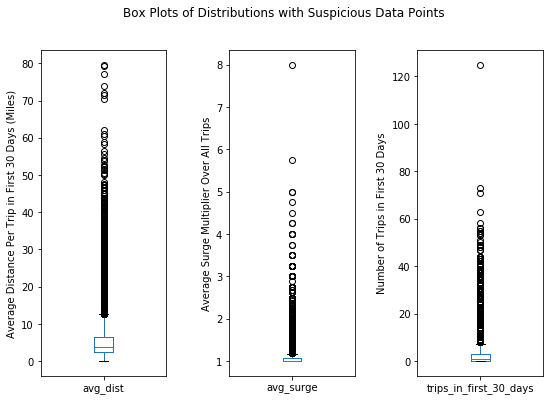

In [22]:
# columns with potential suspicious data points
inspect_cols = ['avg_dist', 'avg_surge', 'trips_in_first_30_days']

# y labels
ylabels = ['Average Distance Per Trip in First 30 Days (Miles)', 'Average Surge Multiplier Over All Trips', 'Number of Trips in First 30 Days']

# make box plots of suspicious distributions
fig = plt.figure(figsize=(9,6))
for ic, col in enumerate(inspect_cols):
    plt.subplot(1,3,ic + 1)
    df_data_clean[col].plot(kind='box')
    plt.ylabel(ylabels[ic])
    
# adjust subplots    
plt.subplots_adjust(wspace=0.5)

# add a title
plt.suptitle('Box Plots of Distributions with Suspicious Data Points')

In [23]:
# users with average surge multiplier > 4
df_data_clean[df_data_clean.avg_surge > 4]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,user_retained
1136,6.46,5.0,5.0,4.75,Winterfell,2014-01-21,iPhone,2014-01-08,100.0,1,False,100.0,False
2345,3.18,5.0,5.0,5.00,Winterfell,2014-02-05,iPhone,2014-01-02,100.0,0,False,100.0,False
4453,0.69,5.0,5.0,4.25,Winterfell,2014-01-11,Android,2014-01-10,100.0,1,False,100.0,False
11528,5.77,5.0,1.0,8.00,Winterfell,2014-01-01,iPhone,2014-01-01,100.0,1,False,100.0,False
15938,3.37,5.0,5.0,5.00,Winterfell,2014-01-11,Android,2014-01-10,100.0,1,False,100.0,False
25291,1.98,5.0,5.0,5.75,Winterfell,2014-01-01,iPhone,2014-01-01,100.0,1,False,100.0,False
26087,6.99,5.0,5.0,4.25,Winterfell,2014-06-21,iPhone,2014-01-21,100.0,0,False,0.0,True
27876,2.80,5.0,5.0,4.50,Winterfell,2014-06-22,iPhone,2014-01-12,100.0,0,True,0.0,True


In [24]:
# users with more than 50 trips in the first 30 days
df_data_clean[df_data_clean.trips_in_first_30_days > 50]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,user_retained
79,2.86,4.9,4.9,1.00,Astapor,2014-03-05,Android,2014-01-27,0.0,73,True,89.7,False
2528,2.32,4.8,4.9,1.06,Winterfell,2014-06-28,iPhone,2014-01-06,2.9,71,True,85.9,True
9016,2.58,4.7,4.1,1.02,Winterfell,2014-06-30,iPhone,2014-01-05,3.4,53,True,70.5,True
14915,3.27,4.7,4.6,1.03,Winterfell,2014-06-25,iPhone,2014-01-07,5.3,55,True,68.0,True
15377,2.02,4.8,5.0,1.12,King's Landing,2014-06-30,iPhone,2014-01-02,14.4,125,True,72.0,True
24112,3.39,4.6,4.8,1.03,King's Landing,2014-06-30,iPhone,2014-01-22,4.8,55,True,66.5,True
24133,1.45,4.6,4.0,1.07,Astapor,2014-06-29,iPhone,2014-01-10,7.3,63,True,83.3,True
25770,2.19,4.5,4.9,1.10,Winterfell,2014-06-29,iPhone,2014-01-25,9.1,54,True,83.0,True
27758,2.91,4.9,4.9,1.05,King's Landing,2014-07-01,iPhone,2014-01-01,6.8,54,True,70.7,True
30222,3.50,5.0,4.7,1.00,King's Landing,2014-04-23,Android,2014-01-11,0.0,53,True,67.2,False


In [25]:
# users with average distance > 50 miles in the first 30 days
df_data_clean[df_data_clean.avg_dist > 50]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,user_retained
656,60.58,5.0,5.0,1.0,Astapor,2014-05-15,Android,2014-01-28,0.0,0,False,100.0,False
1058,79.69,5.0,5.0,1.0,Winterfell,2014-01-30,iPhone,2014-01-30,0.0,1,False,100.0,False
1211,72.08,5.0,5.0,1.0,Astapor,2014-01-27,iPhone,2014-01-26,0.0,1,False,100.0,False
1695,51.52,4.0,5.0,1.0,Winterfell,2014-01-11,iPhone,2014-01-08,0.0,2,True,100.0,False
6719,62.14,5.0,5.0,1.0,Winterfell,2014-01-18,Android,2014-01-18,0.0,1,True,0.0,False
7742,52.10,5.0,4.0,1.0,Winterfell,2014-01-15,iPhone,2014-01-14,0.0,1,False,100.0,False
11977,53.85,2.0,5.0,1.0,King's Landing,2014-01-26,Android,2014-01-26,0.0,1,False,0.0,False
15770,56.53,5.0,5.0,1.0,Winterfell,2014-01-22,iPhone,2014-01-20,0.0,1,False,100.0,False
15943,71.38,5.0,4.7,1.0,Astapor,2014-05-14,iPhone,2014-01-17,0.0,2,True,100.0,False
17239,54.55,4.3,3.0,1.0,Winterfell,2014-01-24,iPhone,2014-01-09,0.0,3,True,100.0,False


#### Explore User Retention

<div style="background-color: #d9f2d9">
<br>
<p> The results of the Exploratory Data Analysis show that 40% of the users in the cleaned data set were considered retained. </p>
<br>
</div>

In [26]:
# statistics for users in clean data set
n_users = df_data_clean.user_retained.count()
n_retained = np.sum(df_data_clean.user_retained)
n_not_retained = np.sum(df_data_clean.user_retained == False)
p_retained = n_retained / n_users

# show proportion of users retained
print('Clean Data Set -- %i Users' % n_users)
print('users retained = %i' % n_retained)
print('users not retained = %i' % n_not_retained)
print('proportion of users retained = %.2f' % p_retained)

Clean Data Set -- 41445 Users
users retained = 16608
users not retained = 24837
proportion of users retained = 0.40


Text(0, 0.5, 'Count')

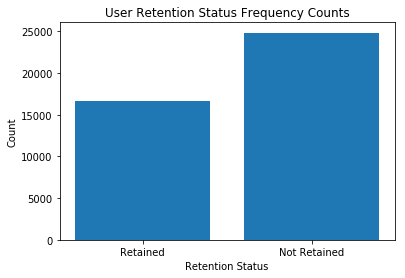

In [27]:
# make a bar chart to show user retention status frequency counts
plt.bar(x=['Retained', 'Not Retained'],
        height=[n_retained, n_not_retained])

# set title and labels
plt.title('User Retention Status Frequency Counts')
plt.xlabel('Retention Status')
plt.ylabel('Count')

#### Test if signup date variable is relevant for analysis

In [28]:
# find earliest and latest signup dates
print('earliest signup date = %s' % df_data_clean.signup_date.min())
print('latest signup date = %s' % df_data_clean.signup_date.max())

earliest signup date = 2014-01-01 00:00:00
latest signup date = 2014-01-31 00:00:00


<div style="background-color: #d9f2d9">
<br>
    
<p> The user signup dates in the cleaned data set range from January 1, 2014 to January 31, 2014. The signup date field was not included in the predictive analysis, because a distinction of the signup date for users in January 2014 is not expected to generalize to signup dates for other months and years.
</p>

<p> In order to further justify this decision, a $\chi^2$ test of independence was performed to determine whether there was an association between user retention and signup date, based on the sample of users in the cleaned data set.  The resulting p-value indicates that, even at a conservative significance level of 0.01, there is no association between user retention and signup date for users who signed up in January 2014.  
</p>

<br>
</div>

In [29]:
# make contingency table
ct = pd.pivot_table(df_data_clean,
                    aggfunc='count',
                    values='avg_dist',
                    index=df_data_clean.signup_date,
                    columns='user_retained',
                    fill_value=0)
    
# get chi^2 test results
chi2, p, dof, exp = chi2_contingency(ct)
    
# print results
print('Chi^2 test of independence for user_retained and signup_date')
print('Chi^2 = %.3f' % chi2)
print('p = %.3e' % p)
print('check condition that all cell expected values >= 5 \nminimum cell expected value = %.2f' % exp.min())

Chi^2 test of independence for user_retained and signup_date
Chi^2 = 123.041
p = 3.143e-13
check condition that all cell expected values >= 5 
minimum cell expected value = 333.00


#### Feature and Target DataFrames

<div style="background-color: #d9f2d9">
<br>
    
<p> Feature and target dataframes were prepared for the predictive analysis. Categorical variables were encoded into dummy variables. The relevant features were copied into a new dataframe, and the target variable was copied into a new dataframe.
</p>
<br>
</div>

In [30]:
# NOTE: dataset is relatively small. Hard coding column names instead of
#       generalizing with a loop over column dtypes. Prioritizing fast
#       short-term results.

# columns of datetimes
dt_cols = ['last_trip_date', 'signup_date']

# categorical columns
cat_cols = ['city', 'phone']

# boolean feature columns
bool_cols = ['ultimate_black_user']

# target column
target_cols = ['user_retained']

In [31]:
# add columns for dummy variables
df_dummy = pd.get_dummies(df_data_clean,
                          columns=cat_cols,
                          drop_first=True)

# convert bool feature to integer type
for col in bool_cols:
    df_dummy[col] = df_dummy[col].astype(np.uint8)

In [32]:
# define feature columns
feature_cols = list(set(df_dummy.columns)
                  - set(dt_cols)
                  - set(target_cols))

In [33]:
# feature dataframe
df_f = df_dummy[feature_cols]

# target dataframe
df_t = df_dummy[target_cols].astype(np.uint8)

### Item 2. Predictive Model

#### Train and Test Sets

<div style="background-color: #d9f2d9">
<br>
    
<p> The cleaned data set was split into train and test sets using stratified random sampling.
</p>
<br>
</div>

In [34]:
# feature and target variable numpy arrays
X = df_f.values
y = df_t.values.flatten()

In [35]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=10)

In [36]:
print('n_train = %i \nn_test  = %i' % (X_train.shape[0], X_test.shape[0]))

n_train = 29011 
n_test  = 12434


#### Baseline Models

<div style="background-color: #d9f2d9">
<br>

<p>
Two baseline models were created, in order to assess which model might be a better candidate as a starting point for the predictive analysis. One baseline model used logistic regression with L2 regularization, using a value of 1 for the regularization parameter C. The other baseline model used a random forest with 20 trees.
</p>

<p>
The baseline models were evaluated using 5-fold cross validation on the entire cleaned data set.  The resulting accuracy scores indicated that the predictive performance of the baseline logistic regression model was comparable to the predictive performance of the baseline random forest model. The baseline random forest model had a higher accuracy score, but the baseline logistic regression model offers better interpretability with reasonable accuracy. 
</p>

<p></p>
<br>
</div>

In [37]:
# baseline logistic regression and random forest
lr_base = LogisticRegression(random_state=10,
                             solver='liblinear')
rf_base = RandomForestClassifier(random_state=10,
                                 n_estimators=20)

# cross validation accuracy scores
acc_lr_base = cross_val_score(lr_base,
                              X,
                              y,
                              scoring='accuracy',
                              cv=5)

acc_rf_base = cross_val_score(rf_base,
                             X,
                             y,
                             scoring='accuracy',
                             cv=5)

print('5-fold cross validation results \n')
print('Logistic Regression w/ L2 Regularization (C=1)\n   mean accuracy = %.3f,  accuracy variance = %.3e' % (np.mean(acc_lr_base), np.var(acc_lr_base)))
print('Random Forest \n   mean accuracy = %.3f,  accuracy variance = %.3e' % (np.mean(acc_rf_base), np.var(acc_rf_base)))

5-fold cross validation results 

Logistic Regression w/ L2 Regularization (C=1)
   mean accuracy = 0.711,  accuracy variance = 1.454e-05
Random Forest 
   mean accuracy = 0.752,  accuracy variance = 6.936e-06


#### Model Selection

<div style="background-color: #d9f2d9">
<br>
There are two main goals of this analysis:
<ol>
  <li> Create a model with strong predictive performance.
  <li> Provide Ultimate with actionable recommendations.
</ol>

<p>The remainder of this analysis will further develop a logistic regression model with L2 regularization in order to fulfill these goals. The logistic regression model was selected because it balances predictive performance with interpretability. If the overall goal was to create a model with the highest possible predictive performance at the expense of interpretability, the random forest model may have been preferred over the logistic regression model.</p>

<br>
</div>

#### Caveats and Considerations

<div style="background-color: #d9f2d9">
<br>
    
<p> Although the logistic regression model is a desirable choice for its intepretability, it has limitations that must be considered. The model assumes independent observations, as well as little to no multicollinearity between features. In addition, the most relevant limitation for this analysis is the requirement that the features are linearly related to the log odds for user retention. </p>

<p>The logistic regression model may not capture the true relationship between the features and the target variable as well as other models which allow for more complicated relationships. Alternative options for analysis techniques include random forests, Principal Component Analysis, and support-vector machines.  These techniques were not selected for this analysis because of their reduced interpretability compared to logistic regression.</p>

<p>The following analysis took care to consider the limitations of the logistic regression model. The logistic regression analysis provided useful results and actionable insights that could benefit Ultimate. </p>
<br>
</div>

#### Model Tuning

<div style="background-color: #d9f2d9">
<br>
    
<p> A pipeline was constructed to standardize the data before fitting or evaluating a logistic regression model with L2 regularization. Two grid searches were performed in sequence in order to select a value for the hyperparameter C. The first grid search explored a large region in parameter space, and the second grid search explored a smaller region around the resulting best value of the first grid search. Both grid searches used 5-fold cross validation on the train set.
</p>

<p> The grid search was performed using accuracy as the scoring metric, because the data set was fairly balanced with roughly 40% user retention. A model's accuracy score reflects its overall ability to make correct predictions.</p>

<p> The results of the grid search indicated that the best value for C was 0.0003. A logistic regression model with L2 regularization using C = 0.0003 was chosen as the final model.
</p>

<br>
</div>

In [38]:
# standard scaler
sc = StandardScaler()

In [39]:
# Logistic Regression
lr = LogisticRegression(random_state=10,
                        solver='liblinear')

# coarse hyperparameter grid
Cs_coarse = list(np.logspace(start=-4,
                             stop=4,
                             num=9))

# coarse parameter grid
params_coarse = {'logistic_regression__C': Cs_coarse}

# pipeline with feature scaling
pipe = Pipeline(steps=[('scaler', sc),
                       ('logistic_regression', lr)])

# initialize GridSearchCV object
clf_coarse = GridSearchCV(pipe,
                          param_grid=params_coarse,
                          cv=5,
                          scoring='accuracy')

# coarse grid search
clf_coarse.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logistic_regression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [40]:
clf_coarse.best_score_

0.7138326841542864

In [41]:
pd.DataFrame(clf_coarse.cv_results_)[['param_logistic_regression__C', 'mean_test_score']]

C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py3

,param_logistic_regression__C,mean_test_score
0,0.0001,0.712764
1,0.001,0.713833
2,0.01,0.713488
3,0.1,0.713764
4,1,0.713798
5,10,0.713729
6,100,0.713729
7,1000,0.713729
8,10000,0.713729


In [42]:
# best hyperparamter value from coarse grid search
best_C_coarse = clf_coarse.best_params_['logistic_regression__C']

In [43]:
# refined hyperparameter grid
Cs = list(np.linspace(best_C_coarse / 10,
                      best_C_coarse,
                      num=9,
                      endpoint=False)) + list(np.linspace(best_C_coarse,
                                                          best_C_coarse * 10,
                                                          num=10))

# refined parameter grid
params = {'logistic_regression__C': Cs}

# initialize GridSearchCV object
clf_refined = GridSearchCV(pipe,
                           param_grid=params,
                           cv=5,
                           scoring='accuracy')

# refined grid search
clf_refined.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logistic_regression__C': [0.0001, 0.00019999999999999998, 0.0003, 0.00039999999999999996, 0.0005, 0.0006000000000000001, 0.0007, 0.0007999999999999999, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [44]:
pd.DataFrame(clf_refined.cv_results_)[['param_logistic_regression__C', 'mean_test_score']]

C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Jon\Anaconda3\envs\py3

,param_logistic_regression__C,mean_test_score
0,0.0001,0.712764
1,0.0002,0.714832
2,0.0003,0.715556
3,0.0004,0.715177
4,0.0005,0.715349
5,0.0006,0.715005
6,0.0007,0.714729
7,0.0008,0.713902
8,0.0009,0.713902
9,0.001,0.713833


In [45]:
# best hyperparameter value from refined grid search
best_C = clf_refined.best_params_['logistic_regression__C']
print('best C = %f' % best_C)

best C = 0.000300


In [46]:
clf_refined.best_score_

0.7155561683499362

In [47]:
# instantiate LogisticRegression object with best C value
lr_best_C = LogisticRegression(C=best_C,
                               random_state=10,
                               solver='liblinear')

# pipeline for best C
pipe_best_C = Pipeline(steps=[('scaler', sc),
                              ('logistic_regression', lr_best_C)])

#### Model Evaluation

<div style="background-color: #d9f2d9">
<br>

<p>The final model was fit on the train set and evaluated on the test set. The baseline models were then fit on the train set and evaluated on the test set in order to compare their performance with the final model's performance. The final model shows slight improvement over the baseline logistic regression model, with an accuracy score of 0.708 on the test set.</p>

<p>The baseline random forest boasts higher accuracy, precision, recall, and f1 score values than either logistic regression model.  The baseline random forest offers better predictive performance, but the logistic regression model offers decent predictive performance with better interpretability.</p>

<br>
</div>

In [48]:
# fit the logistic regression on the train set
pipe_best_C.fit(X_train, y_train)

# get the predicted probabilities for the test set
y_pred_test = pipe_best_C.predict(X_test)

# evaluate the model on the test (holdout) set
print('final model test scores')
print('accuracy  = %.3f' % pipe_best_C.score(X_test, y_test))
print('precision = %.3f' % precision_score(y_test, y_pred_test))
print('recall    = %.3f' % recall_score(y_test, y_pred_test))
print('f1 score  = %.3f' % f1_score(y_test, y_pred_test))

final model test scores
accuracy  = 0.708
precision = 0.681
recall    = 0.537
f1 score  = 0.601


In [49]:
# fit baseline models on train set
lr_base.fit(X_train, y_train)
rf_base.fit(X_train, y_train)

# get baseline model predictions on test set
lr_base_y_pred_test = lr_base.predict(X_test)
rf_base_y_pred_test = rf_base.predict(X_test)

# evaluate baseline models on test set
print('baseline logistic regression model test scores')
print('accuracy  = %.3f' % lr_base.score(X_test, y_test))
print('precision = %.3f' % precision_score(y_test, lr_base_y_pred_test))
print('recall    = %.3f' % recall_score(y_test, lr_base_y_pred_test))
print('f1 score  = %.3f' % f1_score(y_test, lr_base_y_pred_test))
print('')
print('baseline random forest model test scores')
print('accuracy  = %.3f' % rf_base.score(X_test, y_test))
print('precision = %.3f' % precision_score(y_test, rf_base_y_pred_test))
print('recall    = %.3f' % recall_score(y_test, rf_base_y_pred_test))
print('f1 score  = %.3f' % f1_score(y_test, rf_base_y_pred_test))

baseline logistic regression model test scores
accuracy  = 0.705
precision = 0.678
recall    = 0.533
f1 score  = 0.597

baseline random forest model test scores
accuracy  = 0.744
precision = 0.703
recall    = 0.649
f1 score  = 0.675


#### Final Model

<div style="background-color: #d9f2d9">
<br>
    
<p> A pipeline was created to standardize features before performing a logistic regression with L2 regularization using C = 0.0003. The pipeline was then fit on the entire cleaned data set.</p>

<p>This pipeline is the final model that can be used to help Ultimate predict whether a user will be active in their 6th month on the system.</p>

<br>
</div>

In [50]:
# Instantiate the LogisticRegression object
lr_final = LogisticRegression(C=best_C,
                              random_state=10,
                              solver='liblinear')

# make a pipeline
clf_pipe = Pipeline(steps=[('scaler', sc),
                           ('logistic_regression', lr_final)])

# fit the pipeline on the cleaned data set
clf_pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=0.0003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=10,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

#### Statistical Significance

<div style="background-color: #d9f2d9">
<br>

<p>The validity of the final model was assessed by evaluating the statistical significance of the standardized regression coefficients. The p-values of the standardized regression coefficients were obtained to determine whether each coefficient was significantly different from 0.  Unfortunately, scikit-learn does not readily support statistical inference on logistic regression models, and statsmodels does not readily support logistic regression with L2 regularization. The p-values for the standardized coefficients were obtained using a function copied from
<a href="https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance">this forum</a>.
</p>

<p>The resulting p-values indicated that, at a significance level of 0.05, all but two of the standardized regression coefficients were significantly different from 0. The results indicated that the standardized coefficients for <b>avg_surge</b> and <b>surge_pct</b> were not significantly different from 0. 
<br>
</div>

In [51]:
# the following function was copied from the solution posted on  https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [52]:
# scale the cleaned data set
X_scaled = sc.transform(X)

# evaluate the p-values for the standardized coefficients
P = logit_pvalue(lr_final, X_scaled)

# add the intercept to the array of coefficients
coefs = np.concatenate((lr_final.intercept_, lr_final.coef_[0]))

# add p-values to numpy array of coefficients w/ intercept
coefs_pvalues_with_intercept = np.concatenate((np.expand_dims(coefs, axis=1), np.expand_dims(P, axis=1)), axis=1)

In [53]:
# dataframe with standardized coefficients and p-values
df_standardized_coeffs_intercept = pd.DataFrame(index=['Intercept'] + df_f.columns.tolist(),
                                                data=coefs_pvalues_with_intercept,
                                                columns=['Standardized Coefficient', 'P>|z|'])

# display the dataframe with standardized coefficients and p-values
df_standardized_coeffs_intercept.sort_values('Standardized Coefficient')

,Standardized Coefficient,P>|z|
Intercept,-0.320660,0.000000e+00
avg_dist,-0.124213,0.000000e+00
avg_rating_by_driver,-0.060322,1.058016e-08
avg_rating_of_driver,-0.021080,4.745882e-02
avg_surge,-0.012269,4.853283e-01
weekday_pct,0.026669,1.370943e-02
surge_pct,0.028577,1.080907e-01
city_Winterfell,0.098005,1.110223e-15
trips_in_first_30_days,0.288705,0.000000e+00
ultimate_black_user,0.310446,0.000000e+00


#### Practical Significance

<div style="background-color: #d9f2d9">
<br>

<p> The practical significance of the final model was assessed by evaluating the importances of the features. The absolute values of the standardized regression coefficients of the final model were compared in order to determine the importance of each feature.  The bar chart below indicates that city, phone, ultimate black usage, and number of trips in the first 30 days are the most important features. These features are considered practically significant.
</p>

<p> Note that precautions were taken in the analysis to avoid collinearities in the data, but the cities may not be totally independent. The feature importances of the individual cities may not be as meaningful as their combined importance. 
</p>

<br>
</div>

Text(0.5, 1.0, 'Feature Importance')

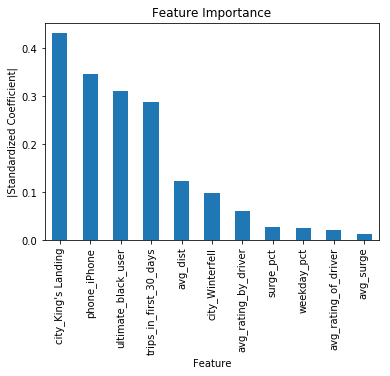

In [54]:
# make a dataframe with absolute values of standardized coefficients
df_abs_standardized_coefficients = np.abs(df_standardized_coeffs_intercept).drop(index='Intercept').sort_values('Standardized Coefficient',
                                                                                                                ascending=False)

# plot the feature importances
df_abs_standardized_coefficients['Standardized Coefficient'].plot(kind='bar',
                                                                  legend=False)
plt.xlabel('Feature')
plt.ylabel('|Standardized Coefficient|')
plt.title('Feature Importance')

#### Follow Up Analysis

<div style="background-color: #d9f2d9">
<br>
    
<p>The results of the logistic regression analysis indicated which features were statistically significant and practically significant. Follow up analysis was performed to investigate some features in more detail. The follow up analysis implemented relatively straightforward techniques in order to gain insight quickly.  </p>

<p>A one-way ANOVA test was performed to determine whether user retention is independent of city.  The results indicated that user retention is not independent of city, for a conservative significance level of 0.01. </p>

<p>A two-sample t-test was performed to determine whether the proportion of user retention for iPhone users is significantly different from the proportion for Android users. The results indicated that the proportion for iPhone users is significantly different than the proportion for Android users, for a conservative significance level of 0.01.</p>
    
<p>A similar two-sample t-test was performed to determine whether the proportion of user retention for users who used ultimate black within the first 30 days is significantly different from the proportion for users who did not.  The results indicated that the proportion for users who used ultimate black in the first 30 days is significantly different than the proportion for users who did not, for a conservative significance level of 0.01.</p>

<p>Follow up analyisis was not performed to evaluate the relationship between user retention and the number of trips taken in the first 30 days, because the analysis of this relationship would be time intensive. </p>

<p>A more in-depth analysis of the important features is recommended in order to determine the relationships between the important features and user retention in more detail. </p>
<br>
</div>

In [55]:
# compare user retention statistics by city
df_data_clean.groupby('city')['user_retained'].agg([np.mean, 'count'])

,mean,count
city,,
Astapor,0.269746,13509
King's Landing,0.648091,8775
Winterfell,0.379782,19161


In [56]:
# one-way ANOVA test
# compare proportions of retained users by City
f_oneway(df_data_clean[df_data_clean.city == 'Astapor'].user_retained,
         df_data_clean[df_data_clean.city == "King's Landing"].user_retained,
         df_data_clean[df_data_clean.city == 'Winterfell'].user_retained)

F_onewayResult(statistic=1754.8882495371856, pvalue=0.0)

In [57]:
# compare user retention statistics by phone type
df_data_clean.groupby('phone')['user_retained'].agg([np.mean, 'count'])

,mean,count
phone,,
Android,0.217729,12093
iPhone,0.476117,29352


In [58]:
# two-sample t-test
# compare proportions of retained users for Android and iPhone users
ttest_ind(df_data_clean[df_data_clean.phone == 'Android'].user_retained,
          df_data_clean[df_data_clean.phone == 'iPhone'].user_retained,
          equal_var=False) 

Ttest_indResult(statistic=-54.37188552568364, pvalue=0.0)

In [59]:
# compare user retention statistics by ultimate black usage
df_data_clean.groupby('ultimate_black_user')['user_retained'].agg([np.mean, 'count'])

,mean,count
ultimate_black_user,,
False,0.314738,25526
True,0.538602,15919


In [60]:
# two-sample t-test
# compare proportions of retained users for ultimate black usage
ttest_ind(df_data_clean[df_data_clean.ultimate_black_user].user_retained,
          df_data_clean[df_data_clean.ultimate_black_user == False].user_retained,
          equal_var=False) 

Ttest_indResult(statistic=45.63750960398649, pvalue=0.0)

### Item 3. Recommendations

<div style="background-color: #d9f2d9">
<br>
<p>The analysis provided insights that are immediately actionable. The results of the analysis could also be expanded upon to deliver further insights.</p>
    
The following actions are recommended to improve long-term rider retention:
<ol>
  <li> Investigate why Android users showed significantly lower user retention than iPhone users.  Explore options to raise retention of Android users, such as improving Ultimate's Android application.</li>
  <li> Investigate why Astapor and Winterfell users showed lower user retention than King's Landing users. Explore options to improve user retention in Winterfell and Astapor, such as issuing promotions.</li>
  <li> Investigate why users who did not use ultimate black within the first 30 days showed lower user retention than users who did. Explore options to encourage ultimate black usage, such as issuing promotions during the user's first 30 days.</li>
  <li> Time permitting, expand upon the results of the analysis in the following ways: </li> 
    <ol>
      <li>Explore the relationships between the important features and user retention in more detail. </li>
      <li>Develop a more advanced predictive model. </li>
    </ol>
</ol>

<br>
</div>